In [1]:
import re
import os.path
import numpy as np
import pickle
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [2]:
class TwitterUser:

    def __init__(self, idd, created, collected, followings,
                 followers, tweets_num, length_name, length_description):
        self._user_id = idd
        self._created_at = created
        self._collected_at = collected
        self._numb_followings = followings
        self._numb_followers = followers
        self._numb_tweets = tweets_num
        self._name_length = length_name
        self._description_length = length_description
        self._tweets = []
        self.t1 = 0
        self.t2 = 0
        self.t3 = 0
        self.t4 = 0
        self.t5 = 0
        self.t6 = 0
        self.t7 = 0
        self.t8 = 0
        self.hashtags = 0
        self._tfidf = []
        self._ratio_follower_following = 0.0
        self._count_http = 0
        self._count_at = 0

In [3]:
def assignInterval(twitter_user,time):
  if  0 <= time <3:
    twitter_user.t1 += 1
  elif 3 <= time < 6:
    twitter_user.t2 += 1
  elif 6<= time < 9:
    twitter_user.t3 += 1
  elif 9 <= time < 12:
    twitter_user.t4 += 1
  elif 12 <= time < 15:
    twitter_user.t5 += 1
  elif 15 <= time < 18:
    twitter_user.t6 += 1
  elif 18<= time < 21:
    twitter_user.t7 += 1
  elif 21 <= time < 24:
    twitter_user.t8 += 1
  

In [4]:
def import_user_data(user_file, tweet_file):
    twitter_users = []
    with open(user_file) as f1:
        all_user_info = f1.readlines()
        for user_info in all_user_info:
            twitter_user_ob = TwitterUser(re.split(r'\t+', user_info)[0], re.split(r'\t+', user_info)[1],
                                          re.split(r'\t+', user_info)[2], float(re.split(r'\t+', user_info)[3]),
                                          float(re.split(r'\t+', user_info)[4]), float(re.split(r'\t+', user_info)[5]),
                                          float(re.split(r'\t+', user_info)[6]), float(re.split(r'\t+', user_info)[7][:-1]))
            twitter_users.append(twitter_user_ob)

    with open(tweet_file) as f2:
        all_user_tweets = f2.readlines()
        for line_tweets_info in all_user_tweets:
            for twitter_user in twitter_users:
                if twitter_user._user_id == re.split(r'\t+', line_tweets_info)[0]:
                    tweets = twitter_user._tweets
                    tweets.append(re.split(r'\t+', line_tweets_info)[2])
                    twitter_user._tweets = tweets
                    assignInterval(twitter_user,int(re.split(r'\t+', line_tweets_info)[3]))

    return twitter_users


In [5]:
def calculate_features(twitter_users):
    for user in twitter_users:

        try:
            tfidf = TfidfVectorizer(min_df=1).fit_transform(user._tweets)
            pairwise_similarity = tfidf * tfidf.T
            user._tfidf = csr_matrix.mean(pairwise_similarity).item()
        except Exception:
            user._tfidf = 0.0
            pass

        if user._numb_followings > 0:
            user._ratio_follower_following = user._numb_followers / user._numb_followings
        else:
            user._ratio_follower_following = 0
        at_count = 0
        http_count = 0
        hash_counts = 0
        for tweet in user._tweets:
            at_count += tweet.count("@")
            http_count += tweet.count("http")
            hash_counts += tweet.count("#")
        user._count_at = at_count
        user._count_http = http_count
        user.hashtags = hash_counts

In [6]:
def build_feature_matrix(twitter_users):
    features_matrix = []

    for user in twitter_users:
        features_matrix.append([user._name_length, user._description_length, user._count_http,
                                user._count_at,user._numb_followings,user._numb_followers, user._ratio_follower_following, user._tfidf,user.t1,user.t2,user.t3,user.t4,user.t5,user.t6,user.t7,user.t8,user.hashtags])

    features_matrix_np = np.array(features_matrix)
    return features_matrix_np

In [7]:
predictUsers = []
def appendToUsers(predictThis):
    for i in predictThis:
	    predictUsers.append(i._user_id)

In [8]:
if os.path.isfile("training/training_labels.dat") and os.path.isfile("training/training_features_matrix.dat") and os.path.isfile("testing/testing_labels.dat") and os.path.isfile("testing/testing_features_matrix.dat"):
    training_labels = pickle.load(open("training/training_labels.dat", "rb"))
    training_features = pickle.load(open("training/training_features_matrix.dat", "rb"))
    testing_labels = pickle.load(open("testing/testing_labels.dat", "rb"))
    testing_features = pickle.load(open("testing/testing_features_matrix.dat", "rb"))
    testing_legit = import_user_data("testing/legitimate_users.txt", "testing/legitimate_users_tweets(mod).txt")
    testing_spammers = import_user_data("testing/spammers.txt", "testing/spammers_tweets(mod).txt")
    appendToUsers(testing_legit)
    appendToUsers(testing_spammers)
else:
    training_spammers = import_user_data("training/spammers.txt", "training/spammers_tweets(mod).txt")
    calculate_features(training_spammers)
    training_spammers_feature_matrix = build_feature_matrix(training_spammers)

    training_legit = import_user_data("training/legitimate_users.txt", "training/legitimate_users_tweets(mod).txt")
    calculate_features(training_legit)
    training_legit_feature_matrix = build_feature_matrix(training_legit)

    training_labels = [0] * len(training_spammers_feature_matrix) + [1] * len(training_legit_feature_matrix) #0 spammers, 1 - legit
    with open('training/training_labels.dat', 'wb') as outfile:
        pickle.dump(training_labels, outfile)

    training_features = np.concatenate((training_spammers_feature_matrix, training_legit_feature_matrix), axis=0)
    with open('training/training_features_matrix.dat', 'wb') as outfile:
        pickle.dump(training_features, outfile)

    testing_spammers = import_user_data("testing/spammers.txt", "testing/spammers_tweets(mod).txt")
    calculate_features(testing_spammers)
    testing_spammers_feature_matrix = build_feature_matrix(testing_spammers)
    appendToUsers(testing_spammers)
    testing_legit = import_user_data("testing/legitimate_users.txt", "testing/legitimate_users_tweets(mod).txt")
    calculate_features(testing_legit)
    testing_legit_feature_matrix = build_feature_matrix(testing_legit)
    appendToUsers(testing_legit)
    testing_labels = [0] * len(testing_spammers_feature_matrix) + [1] * len(testing_legit_feature_matrix)
    with open('testing/testing_labels.dat', 'wb') as outfile:
        pickle.dump(testing_labels, outfile)

    testing_features = np.concatenate((testing_spammers_feature_matrix, testing_legit_feature_matrix), axis=0)
    with open('testing/testing_features_matrix.dat', 'wb') as outfile:
        pickle.dump(testing_features, outfile)


In [9]:
training_features.shape


(691, 17)

In [10]:
df = pd.DataFrame(data=training_features,columns=["name_length","bio_length","count_http","count_@","followings","followers","ratio","tfidf","t1",
                                          "t2","t3","t4","t5","t6","t7","t8","hashtags"])

In [11]:
df['category'] = training_labels
df['category'] = df['category'].map({0:'spam',1:'legit'})

In [12]:
df

,name_length,bio_length,count_http,count_@,followings,followers,ratio,tfidf,t1,t2,t3,t4,t5,t6,t7,t8,hashtags,category
0,8.0,132.0,141.0,68.0,3269.0,3071.0,0.939431,0.039913,32.0,10.0,3.0,5.0,12.0,52.0,45.0,41.0,18.0,spam
1,9.0,134.0,130.0,59.0,1949.0,793.0,0.406875,0.038745,49.0,63.0,8.0,11.0,13.0,0.0,12.0,42.0,101.0,spam
2,12.0,158.0,53.0,111.0,1119.0,9644.0,8.618409,0.032567,16.0,88.0,39.0,40.0,5.0,8.0,0.0,1.0,131.0,spam
3,11.0,121.0,64.0,91.0,2174.0,6029.0,2.773229,0.028722,28.0,1.0,2.0,26.0,31.0,33.0,32.0,47.0,19.0,spam
4,6.0,70.0,138.0,21.0,7731.0,7029.0,0.909197,0.070456,4.0,0.0,15.0,11.0,29.0,35.0,26.0,80.0,2.0,spam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,9.0,137.0,189.0,134.0,1835.0,1376.0,0.749864,0.031153,0.0,17.0,62.0,39.0,45.0,16.0,11.0,10.0,67.0,legit
687,7.0,158.0,40.0,206.0,9524.0,9955.0,1.045254,0.049139,0.0,25.0,50.0,21.0,28.0,47.0,27.0,2.0,4.0,legit
688,8.0,0.0,23.0,70.0,111.0,82.0,0.738739,0.030646,9.0,6.0,18.0,37.0,57.0,44.0,27.0,2.0,11.0,legit
689,10.0,54.0,20.0,167.0,156.0,223.0,1.429487,0.027688,51.0,22.0,13.0,30.0,1.0,6.0,29.0,48.0,97.0,legit


In [13]:
df.describe()

,name_length,bio_length,count_http,count_@,followings,followers,ratio,tfidf,t1,t2,t3,t4,t5,t6,t7,t8,hashtags
count,691.000000,691.000000,691.000000,691.000000,691.000000,6.910000e+02,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,8.962373,71.136035,76.476122,92.775687,4229.986975,6.399226e+03,10.073491,0.040463,17.156295,18.593343,23.570188,29.054993,26.620839,25.141823,23.360347,21.429812,25.298119
std,2.953019,50.955667,64.129515,77.139834,8888.801504,4.765531e+04,181.377793,0.043085,15.963505,19.956356,19.216514,20.137351,20.372711,17.239830,17.364434,18.592010,46.553547
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.005099,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,28.000000,24.000000,26.000000,210.500000,3.285000e+02,0.909097,0.025799,3.000000,1.000000,8.000000,14.000000,10.000000,11.000000,9.000000,5.000000,2.000000
50%,8.000000,63.000000,56.000000,89.000000,858.000000,1.003000e+03,1.030303,0.031778,14.000000,12.000000,21.000000,27.000000,25.000000,25.000000,23.000000,19.000000,9.000000
75%,11.000000,115.000000,122.000000,142.500000,3789.500000,5.416500e+03,1.603640,0.041387,28.000000,31.000000,36.000000,40.000000,40.000000,36.000000,34.000000,32.000000,29.000000
max,15.000000,160.000000,322.000000,973.000000,99778.000000,1.234960e+06,4721.000000,0.483126,80.000000,105.000000,112.000000,121.000000,133.000000,107.000000,131.000000,112.000000,647.000000


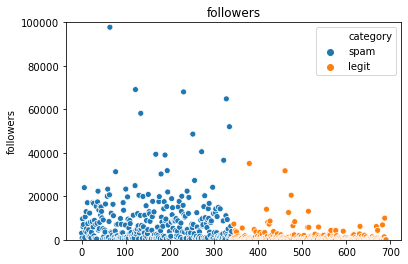

In [37]:
ax = sns.scatterplot(data=df, x=df.index, y='followers',hue='category')
ax.set(ylim=(0, 100000))
plt.title('followers')
plt.show()

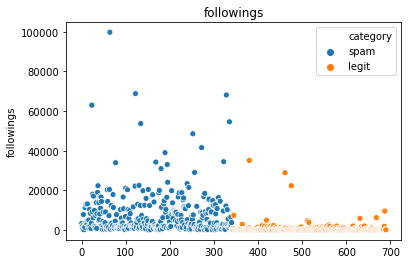

In [15]:
sns.scatterplot(data=df, x=df.index, y='followings',hue='category')
plt.title('followings')
plt.show()

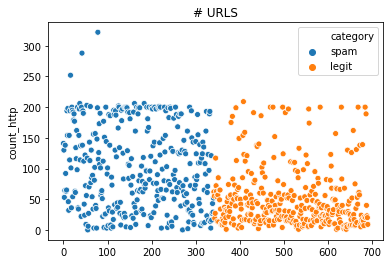

In [16]:
sns.scatterplot(data=df, x=df.index, y='count_http',hue='category')
plt.title('# URLS')
plt.show()

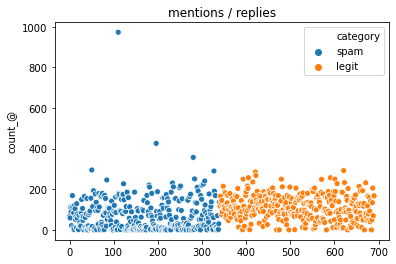

In [17]:
sns.scatterplot(data=df, x=df.index, y='count_@',hue='category')
plt.title('mentions / replies')
plt.show()

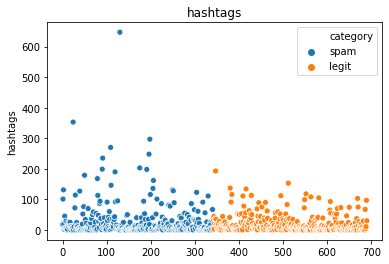

In [18]:
sns.scatterplot(data=df, x=df.index, y='hashtags',hue='category')
plt.title('hashtags')
plt.show()

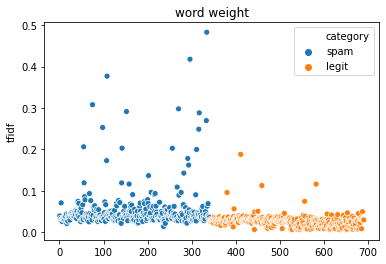

In [19]:
sns.scatterplot(data=df, x=df.index, y='tfidf',hue='category')
plt.title('word weight')
plt.show()

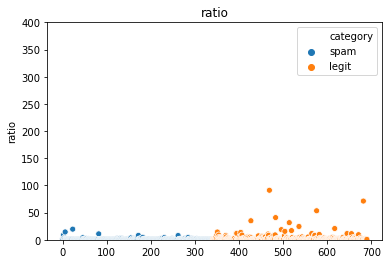

In [43]:
ax = sns.scatterplot(data=df, x=df.index, y='ratio',hue='category')
ax.set(ylim = (0,400))
plt.title('ratio')
plt.show()

In [21]:
def plot_timeslots():
    spam = df[df['category']=='spam']
    spam = spam[['t1','t2','t3','t4','t5','t6','t7','t8']].mean()
    spam = spam.to_frame()
    
    legit = df[df['category']=='legit']
    legit = legit[['t1','t2','t3','t4','t5','t6','t7','t8']].mean()
    legit = legit.to_frame()
    concated = legit.append(spam, ignore_index=True)
    d = {'timeslots': ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8','t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8'], 'category': ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'legit','legit','legit','legit','legit','legit','legit','legit']}
    frequency = pd.DataFrame(data=d)
    frequency['count'] = concated
    return frequency

In [22]:
frequency =  plot_timeslots()

In [23]:
frequency

,timeslots,category,count
0,t1,spam,20.625714
1,t2,spam,23.737143
2,t3,spam,28.274286
3,t4,spam,29.768571
4,t5,spam,23.474286
5,t6,spam,24.125714
6,t7,spam,23.380000
7,t8,spam,23.525714
8,t1,legit,13.595308
9,t2,legit,13.313783


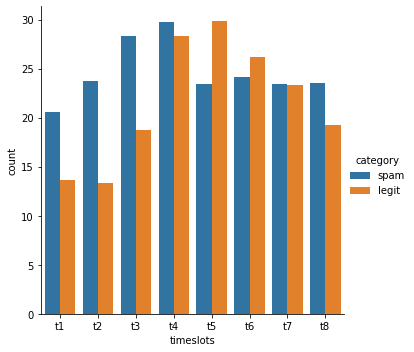

In [24]:
sns.catplot(x="timeslots", y="count", hue="category", data=frequency, kind="bar")

In [25]:
def select_classifier(algo, label):
    model = algo
    model.fit(training_features, training_labels)
    expected = testing_labels
    predicted = model.predict(testing_features)
    
    print("----------------------------------------------------")
    print("|               Classification Report              |")
    print("----------------------------------------------------")
    print(metrics.classification_report(expected, predicted))
    print("")
    conf_mat = confusion_matrix(expected,predicted)
    df_confussion = pd.DataFrame(conf_mat,index=['actual legit','actual spam'],columns=['predicted legit','predicted spam'])
    sns.heatmap(df_confussion, annot=True)

----------------------------------------------------
|               Classification Report              |
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       150
           1       0.91      0.77      0.83       150

    accuracy                           0.84       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.84      0.84       300




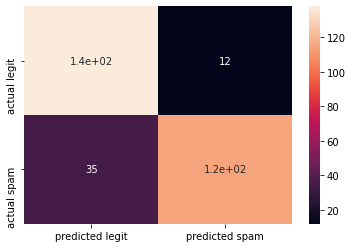

In [26]:
select_classifier(GaussianNB(), "Naive Bias Classifier")

----------------------------------------------------
|               Classification Report              |
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       150
           1       0.94      0.89      0.92       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300




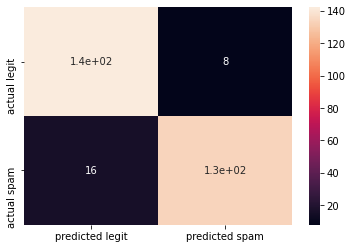

In [27]:
select_classifier(RandomForestClassifier(), "random forest classifier")

----------------------------------------------------
|               Classification Report              |
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.51      0.66       150
           1       0.66      0.97      0.79       150

    accuracy                           0.74       300
   macro avg       0.80      0.74      0.72       300
weighted avg       0.80      0.74      0.72       300




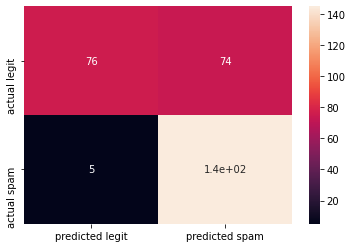

In [28]:
select_classifier(svm.SVC(), "SVM classifier")

----------------------------------------------------
|               Classification Report              |
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       150
           1       0.92      0.89      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300




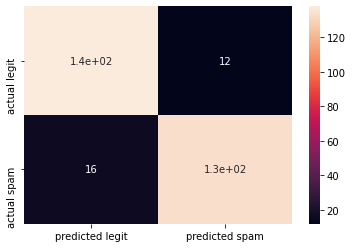

In [29]:
select_classifier(KNeighborsClassifier(n_neighbors = 6), "K Nearest Neighbour Classifier")

In [44]:
def plot_comparisons():
    
    d = {'Metric': ['Accuracy', 'Precision', 'Recall','F-measure','Accuracy', 'Precision', 'Recall','F-measure','Accuracy', 'Precision', 'Recall','F-measure','Accuracy', 'Precision', 'Recall','F-measure'], 'Classifier': ['Naive Bayes', 'Naive Bayes', 'Naive Bayes', 'Naive Bayes', 'Random Forest', 
    'Random Forest', 'Random Forest', 'Random Forest','SVM','SVM','SVM','SVM','KNN','KNN','KNN','KNN'],'Values':[85,80,92,85,92,90,94,92,80,94,51,66,91,90,92,91]}
    comparisons = pd.DataFrame(data=d)
    return comparisons

In [45]:
comparisons=plot_comparisons()
comparisons

,Metric,Classifier,Values
0,Accuracy,Naive Bayes,85
1,Precision,Naive Bayes,80
2,Recall,Naive Bayes,92
3,F-measure,Naive Bayes,85
4,Accuracy,Random Forest,92
5,Precision,Random Forest,90
6,Recall,Random Forest,94
7,F-measure,Random Forest,92
8,Accuracy,SVM,80
9,Precision,SVM,94


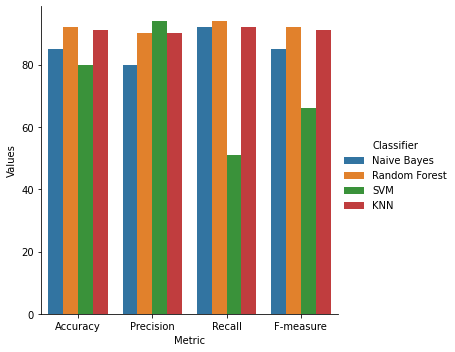

In [46]:
sns.catplot(x="Metric", y="Values", hue="Classifier", data=comparisons, kind="bar")